In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt

import sys
import os
py_file_location = "/content/drive/My Drive"
sys.path.append(os.path.abspath('/content/drive/MyDrive/NeuralNetwork'))

from experimenting_basket_helper import *
from models_hs import *
from trainer import *
from preprocess import *
from callbacks import *


# 0 Data

Read in data for each dimension and store as `pd.DataFrame`:

In [5]:
dims = [1, 4, 7, 10, 13, 16]
dataframes_list = get_dfs(dims, 1000)

# print the dataframe for dim 1 for checking
dataframes_list[0]

,days_to_maturity,strike,volatility,mean_volatility,reversion,vol_of_var,rate,Underlying_0,Rho_0,contract_price
0,52.0,16.50,0.010564,0.041048,1.775966,0.058849,0.015002,17.332500,-0.333905,10.938264
1,21.0,49.50,0.039117,0.049353,1.540456,0.489135,0.001440,9.260000,-0.129997,0.571392
2,31.0,14.00,0.029249,0.006491,0.982883,0.224651,0.017221,16.414301,-0.462886,8.445650
3,18.0,8.70,0.038737,0.016305,2.372708,0.329505,0.006641,15.892000,-0.141496,9.129831
4,59.0,16.50,0.043640,0.038880,4.562963,0.706960,0.053901,11.277000,-0.379364,10.687387
...,...,...,...,...,...,...,...,...,...,...
995,38.0,13.00,0.001502,0.046531,1.663993,0.145838,0.001362,12.819120,-0.307483,6.298129
996,85.0,15.00,0.042181,0.044124,0.302489,0.661890,0.018707,18.106250,-0.050286,24.277845
997,29.0,0.48,0.033398,0.005511,4.443828,0.506015,0.002109,67.483701,-0.693189,65.758164
998,7.0,9.50,0.004519,0.036562,2.277263,0.288585,0.003034,15.919620,-0.470891,7.345720


Prepare datasets for all dimensions:

In [6]:
train_datasets, valid_datasets, test_datasets = [None]*len(dims), [None]*len(dims), [None]*len(dims)
for i, _ in enumerate(dims):
    train_datasets[i], valid_datasets[i], test_datasets[i] = pipeline1(dataframes_list[i].to_numpy(), scaling=True, prefetch=True)

(800, 10) (100, 10) (100, 10)
(800, 16) (100, 16) (100, 16)
(800, 22) (100, 22) (100, 22)
(800, 28) (100, 28) (100, 28)
(800, 34) (100, 34) (100, 34)
(800, 40) (100, 40) (100, 40)


# 1 Hyperparmaters Tuning

Bulid the model to be tuned:

In [7]:
def model_builder_hs(dim,
                num_layers   = 2,
                hidden_units = [14,7],
                output_shape = (1,),
                activation = 'elu',
                regularizer = None,
                initializer = tf.keras.initializers.he_uniform(),
                final_activation = 'linear',
                dropout = None,
                batchnorm = False
                ): 
        """
        Returns a model for training and testing.  

        Args:
            - dim: int, basket size
            - num_layers: int, number of hidden layers
            - hidden_units: list of number of hidden units in each layer
            - output_shape: shape of the output data
            - activation: string, activation function
            - initializer: initializer for the weights
            - final_activation: string, activation function of final layer
            - dropout: list, dropout rate for each layer, default None
            - batchnorm: bool, specifies if batch normalization is used, default False 
        
        Output:  
            - model: tf.keras.Model, compiled if compile is True
        """  
        assert num_layers == len(hidden_units), "Number of hidden units must match number of layers"
        if dropout is not None:  
            assert num_layers == len(dropout), "Number of dropout rates must match number of layers"

        input_shape = (7 + 2*dim,)

        inputs = tf.keras.layers.Input(shape=input_shape)
        h = tf.keras.layers.Flatten()(inputs)

        for i, layer in enumerate(hidden_units):
            h = tf.keras.layers.Dense(layer, activation=activation, kernel_regularizer= regularizer,
                                    kernel_initializer = initializer)(h)
            if dropout:
                h = tf.keras.layers.Dropout(dropout[i])(h)
            if batchnorm:
                h = tf.keras.layers.BatchNormalization()(h)
        if final_activation is not None:
            outputs = tf.keras.layers.Dense(output_shape[0], activation=final_activation,
                                            kernel_initializer = initializer)(h)
        else:
            outputs = tf.keras.layers.Dense(output_shape[0], 
                                            kernel_initializer = initializer)(h)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)  

        return model   


def tuned_model_hs(hp):
        """
        Returns a compiled hyperModel for keras tuner. 

        """  

        # defining a set of hyperparameters for tuning and a range of values for each
        num_layers = hp.Int('num_layers', min_value=1, max_value=5) 
        activation = hp.Choice('activation', ['elu','tanh', 'relu', 'sigmoid'])
        learning_rate = hp.Float('learning_rate', min_value=10**(-3), max_value=0.01)
        rate_decay = hp.Float('rate_decay', min_value=0.85, max_value=0.9995)
        l1_reg = hp.Float('l1_regularizer', min_value=10**(-8), max_value=10**(-6.5))
        l2_reg = hp.Float('l1_regularizer', min_value=10**(-8), max_value=10**(-6.5))
        batchnorm = hp.Boolean(name = 'batchnorm')
        
        hidden_units, dropouts = [],[]
        for i in range(num_layers):
            hidden_unit = hp.Int(f'units_{i+1}', min_value=5, max_value=7)
            hidden_units.append(hidden_unit)
            dropout = hp.Float(f'dropout_{i+1}', min_value=0.0, max_value=0.5, step=0.1)
            dropouts.append(dropout)

        model = model_builder_hs(dim,
                        num_layers = num_layers, 
                        hidden_units = hidden_units,
                        dropout = dropouts,
                        activation = activation,
                        batchnorm = batchnorm,
                        regularizer = tf.keras.regularizers.l1_l2(l1_reg,l2_reg)
                        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            learning_rate, decay_steps = 4000, decay_rate = rate_decay, staircase = True)
        
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), loss = tf.keras.losses.MeanAbsolutePercentageError(), 
                    metrics = [tf.keras.metrics.MeanSquaredError()])

        return model  

## 1.1 Using Random Tuner:

In [8]:
random_tuners, best_hp_list_rn, best_models_rn = [None] * len(dims), [None] * len(dims), [None] * len(dims)

for i, dim in enumerate(dims):
    random_tuners[i]=kt.RandomSearch(
    hypermodel=tuned_model_hs, # the hypermodel to tune # can be tuneLR or tuneLayer
    objective="val_loss", # the objective to optimize
    max_trials=3, # the maximum number of trials to run
    executions_per_trial=2, # the number of models generated on each trial
    overwrite=True, # whether to overwrite previous trials
    directory="hyperparams/RandomSearch", # the directory to save the trials
    project_name=f"basket_option_{dim}", # the name of the project
    )  

    best_hp_list_rn[i], best_models_rn[i] = using_tuner(i, train_datasets, valid_datasets, random_tuners)

Trial 3 Complete [00h 00m 10s]
val_loss: 5583231.625

Best val_loss So Far: 839070.53125
Total elapsed time: 00h 00m 18s


The best combination of hyperparameters using Random Tuner:

In [10]:
pd.DataFrame([best_hp_list_rn[i].values for i in range(len(dims))], index = dims)

,num_layers,activation,learning_rate,rate_decay,l1_regularizer,batchnorm,units_1,dropout_1,units_2,dropout_2,units_3,dropout_3,units_4,dropout_4,units_5,dropout_5
1,5,tanh,0.008037,0.976837,2.526668e-07,True,6,0.4,6,0.4,7.0,0.4,7.0,0.5,7.0,0.5
4,2,elu,0.007432,0.863614,1.959299e-08,True,6,0.4,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2,elu,0.008687,0.993994,1.558946e-07,False,7,0.4,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
10,4,relu,0.002686,0.974875,2.118243e-07,False,6,0.2,7,0.1,5.0,0.3,5.0,0.0,NaN,NaN
13,3,elu,0.005473,0.958470,6.025332e-08,False,6,0.5,5,0.2,6.0,0.1,NaN,NaN,NaN,NaN
16,4,tanh,0.002833,0.928667,7.033188e-08,False,6,0.3,5,0.0,5.0,0.0,5.0,0.0,NaN,NaN


## 1.2 Using Hyperband Tuner:


In [11]:
hyperband_tuners, best_hp_list_hb, best_models_hb = [None] * len(dims),[None] * len(dims),[None] * len(dims)

for i, dim in enumerate(dims):

    hyperband_tuners[i] = kt.Hyperband(
    hypermodel=tuned_model_hs, # the hypermodel to tune # can be tuneLR or tuneLayer
    objective="val_loss", # the objective to optimize
    max_epochs=10,
    factor=3,
    directory="hyperparams/HyperbandSearch", # the directory to save the trials
    project_name=f"basket_option_{dim}", # the name of the project
    )  

    best_hp_list_hb[i], best_models_hb[i] = using_tuner(i, train_datasets, valid_datasets, hyperband_tuners)

The best combination of hyperparameters using Hyperband Tuner:

In [13]:
pd.DataFrame([best_hp_list_hb[i].values for i in range(len(dims))], index = dims)

,num_layers,activation,learning_rate,rate_decay,l1_regularizer,batchnorm,units_1,dropout_1,units_2,dropout_2,...,dropout_3,units_4,dropout_4,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,units_5,dropout_5,tuner/trial_id
1,5,relu,0.006804,0.890436,1.794370e-07,False,5,0.1,5,0.1,...,0.3,6,0.3,2,0,2,0,5.0,0.0,NaN
4,3,relu,0.005248,0.942470,2.906948e-07,False,7,0.1,6,0.4,...,0.1,6,0.5,10,0,0,0,6.0,0.0,NaN
7,3,relu,0.003620,0.937495,6.561854e-08,False,6,0.4,6,0.5,...,0.2,6,0.5,10,4,1,1,6.0,0.1,0022
10,3,relu,0.003940,0.978665,8.429799e-08,False,7,0.1,5,0.2,...,0.3,6,0.3,10,0,0,0,NaN,NaN,NaN
13,5,relu,0.001627,0.995648,1.624884e-07,False,7,0.5,6,0.3,...,0.3,6,0.1,10,0,0,0,5.0,0.4,NaN
16,1,relu,0.007415,0.988477,1.145353e-07,False,6,0.0,5,0.3,...,0.3,6,0.2,4,0,1,0,7.0,0.1,NaN


## 1.3 Using Bayesian Optimization

In [14]:
bayes_tuners, best_hp_list_bo, best_models_bo = [None] * len(dims), [None] * len(dims), [None] * len(dims)

for i, dim in enumerate(dims):

    bayes_tuners[i] = kt.BayesianOptimization(
    hypermodel=tuned_model_hs, # the hypermodel to tune # can be tuneLR or tuneLayer
    objective="val_loss", # the objective to optimize
    max_trials=3,
    directory="hyperparams/BayesianOptimization", # the directory to save the trials
    project_name=f"basket_option_{dim}", # the name of the project
    )  

    best_hp_list_bo[i], best_models_bo[i] = using_tuner(i, train_datasets, valid_datasets, bayes_tuners)

The best combination of hyperparameters using Bayesian Optimization:

In [15]:
pd.DataFrame([best_hp_list_bo[i].values for i in range(len(dims))], index = dims)

,num_layers,activation,learning_rate,rate_decay,l1_regularizer,batchnorm,units_1,dropout_1,units_2,dropout_2,units_3,dropout_3,units_4,dropout_4,units_5,dropout_5
1,2,tanh,0.008448,0.951111,1.354144e-07,False,7,0.2,6,0.4,6,0.2,NaN,NaN,NaN,NaN
4,5,sigmoid,0.001000,0.850000,1.000000e-08,False,7,0.0,5,0.0,5,0.4,5.0,0.0,5.0,0.0
7,1,sigmoid,0.010000,0.999500,1.000000e-08,False,5,0.0,7,0.2,5,0.2,6.0,0.0,6.0,0.0
10,5,sigmoid,0.001000,0.850000,3.162278e-07,False,5,0.5,5,0.4,5,0.0,5.0,0.0,5.0,0.0
13,4,sigmoid,0.002185,0.978346,2.344421e-07,False,7,0.0,6,0.1,5,0.0,5.0,0.0,NaN,NaN
16,5,tanh,0.010000,0.850000,1.000000e-08,False,5,0.5,6,0.2,6,0.2,5.0,0.1,5.0,0.0


# 2 Training

## 2.1 Using hyperparameters from Random Tuner

In [ ]:
best_models_history_rn = []
begin_train_rn, end_train_rn = [0]*len(dims),[0]*len(dims)

for i, _ in enumerate(dims):
    begin_train_rn[i] = time.time()
    history = best_models_rn[i].fit(train_datasets[i], epochs = 10, validation_data = valid_datasets[i])
    end_train_rn[i] = time.time()
    best_models_history_rn.append(history)

Display best validation MSE:

In [17]:
best_val_mse_rn = pd.DataFrame([min(best_models_history_rn[i].history['val_mean_squared_error']) for i in range(6)], index = dims, columns = ['Best Validation MSE'])
best_val_mse_rn

,Best Validation MSE
1,0.006426
4,0.016119
7,0.024461
10,0.000132
13,0.006564
16,0.014327


#2.2 Using hyperparameters from Hyperband Tuner

In [ ]:
best_models_history_hb =[]
begin_train_hb, end_train_hb = [0]*len(dims),[0]*len(dims)

for i, _ in enumerate(dims):
    begin_train_hb[i] = time.time()
    history = best_models_hb[i].fit(train_datasets[i], epochs = 10, validation_data = train_datasets[i])
    end_train_hb[i] = time.time()
    best_models_history_hb.append(history)

Display best validation MSE:

In [19]:
best_val_mse_hb = pd.DataFrame([min(best_models_history_hb[i].history['val_mean_squared_error']) for i in range(6)], index = dims, columns = ['Best Validation MSE'])
best_val_mse_hb

,Best Validation MSE
1,0.006998
4,0.014966
7,0.043037
10,0.001368
13,0.016351
16,0.005551


## 2.3 Using hyperparameters from Bayesian Optimization

In [ ]:
begin_train_bo, end_train_bo = [0]*len(dims),[0]*len(dims)
best_models_history_bo = []

for i, _ in enumerate(dims):
    begin_train_bo[i] = time.time()
    history = best_models_bo[i].fit(train_datasets[i], epochs = 10, validation_data = valid_datasets[i])
    end_train_bo[i] = time.time()
    best_models_history_bo.append(history)

In [21]:
best_val_mse_bo = pd.DataFrame([min(best_models_history_bo[i].history['val_mean_squared_error']) for i in range(6)], index = dims, columns = ['Best Validation MSE'])
best_val_mse_bo

,Best Validation MSE
1,0.006543
4,0.014532
7,0.034480
10,0.000103
13,0.013400
16,0.013197


# 2.4 Comparison between tuners

Compare the validation MSEs to decide which set of hyperparamters to be used for each basket size:

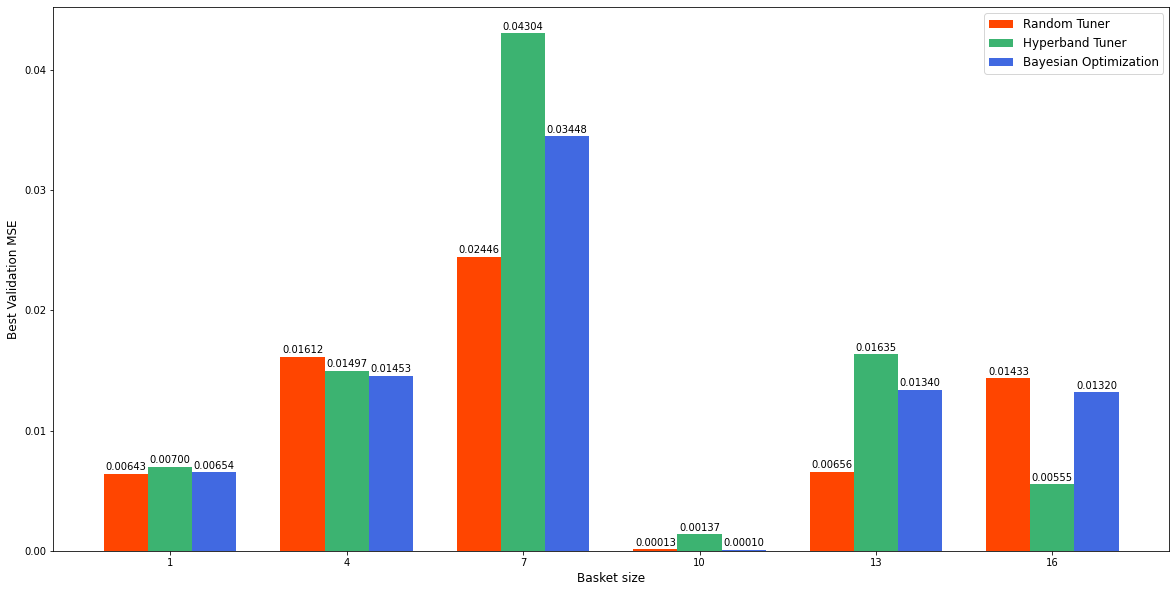

In [23]:
N = len(dims)
ind = np.arange(N) 
width = 0.25
plt.figure(figsize=(20,10))
  
xvals = best_val_mse_rn['Best Validation MSE'].values
bar1 = plt.bar(ind, xvals, width, color = 'orangered')
plt.bar_label(bar1, labels=[f'{x:,.5f}' for x in xvals], padding = 1.5)

  
yvals = best_val_mse_hb['Best Validation MSE'].values
bar2 = plt.bar(ind+width, yvals, width, color='mediumseagreen')
plt.bar_label(bar2, labels=[f'{x:,.5f}' for x in yvals], padding = 1.5)
  
zvals = best_val_mse_bo['Best Validation MSE'].values
bar3 = plt.bar(ind+width*2, zvals, width, color = 'royalblue')
plt.bar_label(bar3, labels=[f'{x:,.5f}' for x in zvals], padding = 1.5)
  
plt.xlabel("Basket size",fontsize=12)
plt.ylabel('Best Validation MSE',fontsize=12)
  
plt.xticks(ind+width,dims)
plt.legend( (bar1, bar2, bar3), ('Random Tuner', 'Hyperband Tuner', 'Bayesian Optimization') ,fontsize=12)
plt.show()

Therefore, we choose:

*   Random tuner for options with basket sizes 1, 7 and 13

*   Hyperband tuner for options with basket sizes 16

*   Bayesian optimization for options with basket sizes 4 and  10 





# 3 Evaluation

In [29]:
results, test_time = evaluate_models(best_models_rn, best_models_hb, best_models_bo, test_datasets)

4/4 [==============================] - 0s 4ms/step - loss: 57496.3906 - mean_squared_error: 0.0036


In [34]:
test_mse = pd.DataFrame(np.array(results)[:,1], index = dims, columns = ['Best Test MSE'])
test_mse

,Best Test MSE
1,0.038504
4,0.011409
7,0.034952
10,0.000196
13,0.017493
16,0.003589


# 4 Visualization

## 4.1 Plotting Training and Testing Time of Neural Network

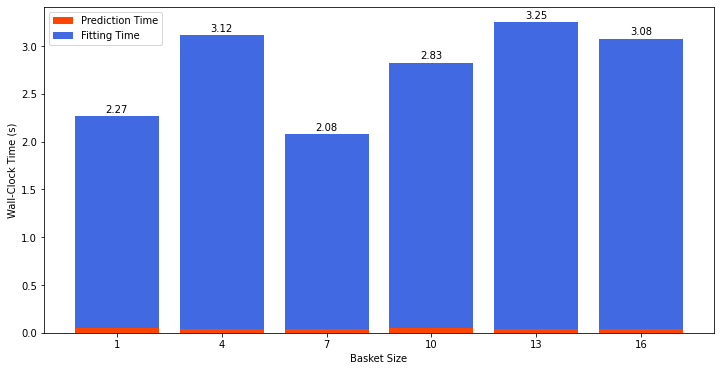

In [31]:
train_time = get_train_time(begin_train_rn,begin_train_hb,begin_train_bo, end_train_rn, end_train_hb, end_train_bo)
x_pos = [i for i, _ in enumerate(dims)]
plt.figure(figsize=(12,6))

plt.bar(x_pos, test_time, color='orangered', label = 'Prediction Time')
bars = plt.bar(x_pos, train_time, bottom = test_time, color='royalblue', label = 'Fitting Time')
plt.bar_label(bars, labels=[f'{x:,.2f}' for x in train_time + test_time],padding = 2)

plt.xlabel('Basket Size')
plt.ylabel('Wall-Clock Time (s)')
plt.xticks(x_pos, dims)
plt.legend(loc = 'upper left')

plt.show()

## 4.2 Comparison between Neural Network and Heston model

Plot the train and test time for neural network against the prediction time for heston model:

In [32]:
df_hs_time = pd.read_csv('/content/drive/MyDrive/data/heston_times.csv')
df_hs_time

,Dimension,Feature Vector Length,Generating Inputs Time,Heston Pricing Time,Saving Time,Total Time Taken
0,1,9,0.046857,5.395159,0.010292,5.454861
1,4,15,0.036379,21.747896,0.013936,21.804359
2,7,21,0.036156,37.924724,0.019062,37.989934
3,10,27,0.036188,54.141018,0.023737,54.214613
4,13,33,0.036353,70.364936,0.027123,70.446901
5,16,39,0.036567,88.826773,0.039852,88.945123


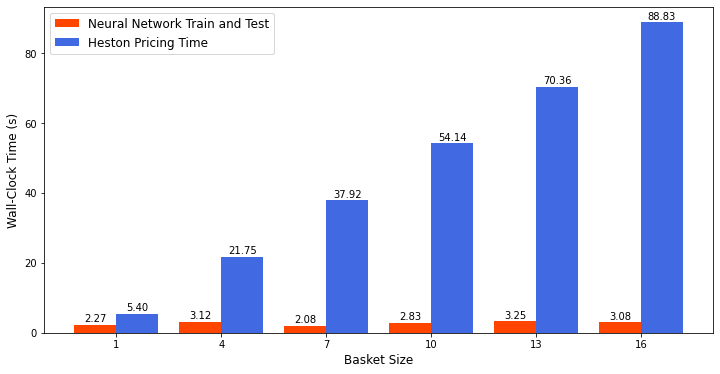

In [33]:
plt.figure(figsize=(12,6))
x_axis = np.arange(1,len(dims)+1)

bars_1 = plt.bar(x_axis -0.2, train_time+test_time, width=0.4, label = 'Neural Network Train and Test', color='orangered')
plt.bar_label(bars_1, labels = [f'{x:,.2f}' for x in bars_1.datavalues],padding=1,fontsize=10)

bars_2 = plt.bar(x_axis +0.2, df_hs_time['Heston Pricing Time'], width=0.4, label = 'Heston Pricing Time',color = 'royalblue')
plt.bar_label(bars_2, labels = [f'{x:,.2f}' for x in bars_2.datavalues],padding=1,fontsize=10)

plt.xticks(x_axis, dims,fontsize=10)
plt.yticks(range(0, 81,20),fontsize=10)
plt.xlabel('Basket Size',fontsize=12)
plt.ylabel('Wall-Clock Time (s)',fontsize=12)
plt.legend(fontsize=12)
plt.show()